# 1. Autoencoder Implementation

## Describe your dataset and the steps that you used to create it
The original dataset consists of many images of emojis that are of size 256x256. I started by using the datasets library to download the emoji dataset from huggin face. After this, dataset needed to be augmented and split into training, validation, and test sets. The first augmentation step was to gather a subset of a the data based on the text in the label. We chose to use the text "face", which includes grinning face, winking face, etc. The gave us ~200 images to work with in total. We then split this set into training, validation, and test with a 60, 20, 20 split respectively using the train_test_split library from sklearn. The next augmentation that needed to be done was to create more data for each split. We created an augment_data function that applied PyTorch transformations to the data that randomly flipped the images, resized them to 3, 64, 64, and converted the images to tensors. We did this 5 times for each set that multiplying the number of images by 5. 

<center>
Original train set: 122, Augmented train set: 610
Original valid set: 41, Augmented valid set: 205
Original test set: 41, Augmented test set: 205
</center>

Finally, we created a loader for each set to easilt iterate through the images when passing them to our model.

## Provide a summary of your architecture
The architecture consists of 5 layers for the encoder and 5 layers for the decoder. We use a "hourglass" architecutre, as do most autoencoders. The first layer is the number of channels (3, RGB) to 128. We use Convolutional Layers to reduce the dimensions to a 2x2 using a kernel size of 3, stride of 2, and padding of 1 for each layer to eventually decrease the image to a 2x2. Then, that output is ran through the decoder, which uses `ConvTranspose2d` which is similar to the inverse of Conv2d. This layer expands the encoded input back into an output that follow the dimensions of the batch size, channels, width, and height. We then utilize these in the forward method of the AE model.

## Discuss and explain your design choices
At first, we were using linear layers, which are not as well suited for image inputs, so switching to Conv2d was essential. We started with an arbitrary number of layers and made sure to match the encoder to the decoder. The main challenge was making sure that input image size was matched by the output size. This took some trial and error, as well as calculating the kernel size, stride, and padding with this formula:

<center>
Output size = ((Input size + 2 * Padding - Kernel size) / Stride) + 1
</center>

For our training script, we made the mistake of making the learning rate too high which caused our model to not learn very well. After dropping the learning rate, the loss decreased quite nicely. Increasing the number of epochs also helped with decreasing the loss, as we found our model needed more time to reach a local minimum. 

## List Hyperparameters used in the model

Hyperparameters:
- Layer Type
- Number of input/ouput channels per layer
- Number of total layers
- Batch size
- Learning Rate
- Resize 
- Transformations
- Loss Function
- Weight Decay
- Optimizer
- Epochs

## Plot learning curves for training and validation loss as a function of training epochs

**Training**
<center>
<img src="loss_plots/training/loss_vs_iterations.png" alt="Alt text" width="300" height="250">
</center>

**Validation**

## Provide the final average error of your autoencoder on your test set


## Provide a side-by-side example of 5 input and output images
<center>
<img src="output_plots/training/input_vs_output.png" alt="Alt text" width="500" height="250">
</center>

## Discuss any decisions or observations that you find relevant

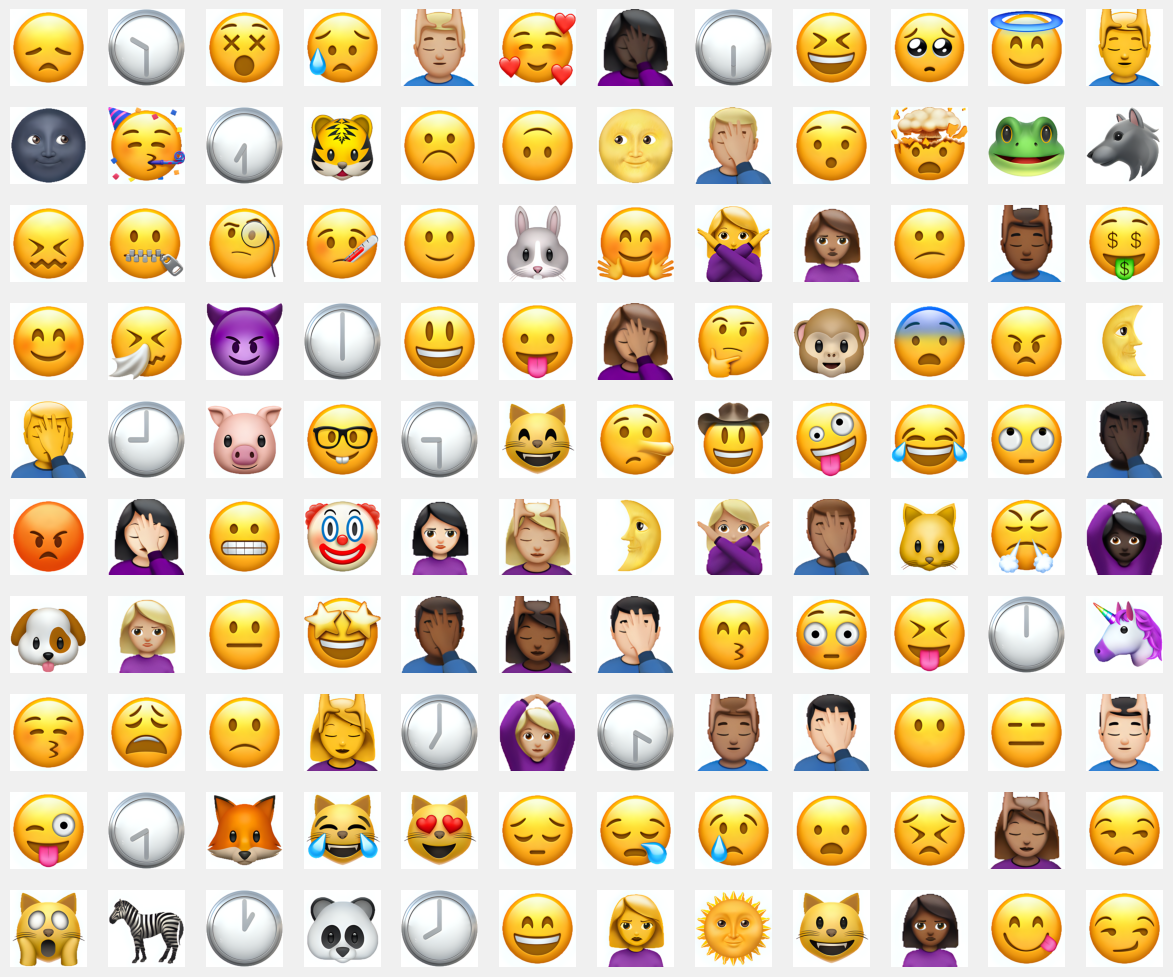

In [17]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from model import AE
import matplotlib.pyplot as plt


dataset_split = []
train_set_augmented = []
valid_set_augmented = []
test_set_augmented = []

dataset = load_dataset("valhalla/emoji-dataset")

# Split data by text
for data in dataset["train"]:
    label = data["text"]
    if label.find("face") != -1:
        dataset_split.append(data)

# Split data into training, validation, and testing sets
train_set, temp_set = train_test_split(dataset_split, test_size=0.4)
test_set, valid_set = train_test_split(temp_set, test_size=0.5)

# Display images from the training set
num_images = len(train_set)
ncols = 12
nrows = num_images // ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
axs = axs.flatten()
for ax, data in zip(axs, train_set):
    ax.imshow(data["image"])
    ax.axis("off")
for ax in axs[num_images:]:
    ax.axis("off")
plt.tight_layout()
plt.show()

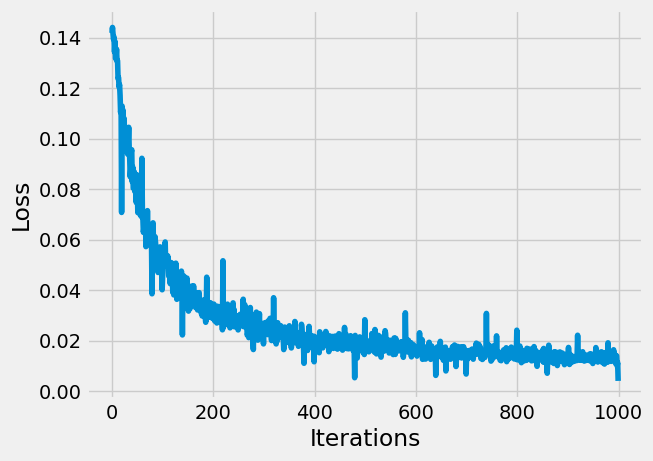

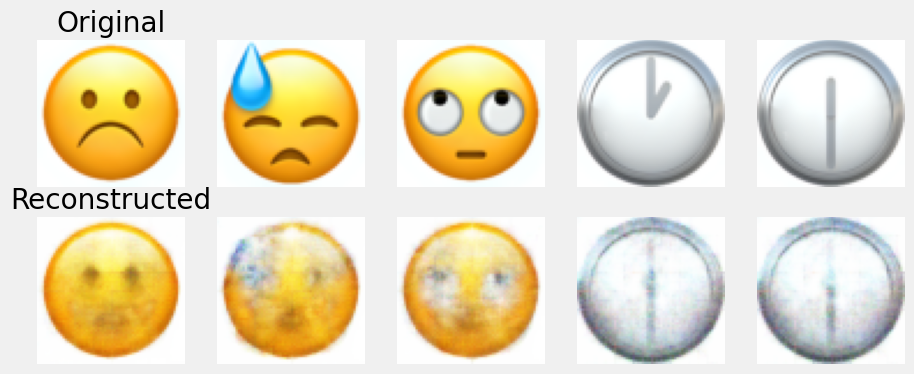

In [ ]:
# Augmentation
transformations = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def augment_images(dataset):
    augmented_data = []
    for data in dataset:
        image = data["image"].convert("RGB")  # Convert to PIL Image
        for _ in range(5):  # Augment each image 5 times
            augmented_data.append(transformations(image))
    return augmented_data


# Apply augmentation
train_set_augmented = augment_images(train_set)
valid_set_augmented = augment_images(valid_set)
test_set_augmented = augment_images(test_set)

# Convert lists to tensors
train_set_augmented = torch.stack(train_set_augmented)
valid_set_augmented = torch.stack(valid_set_augmented)
test_set_augmented = torch.stack(test_set_augmented)

print(
    f"Original train set: {len(train_set)}, Augmented train set: {len(train_set_augmented)}")
print(
    f"Original valid set: {len(valid_set)}, Augmented valid set: {len(valid_set_augmented)}")
print(
    f"Original test set: {len(test_set)}, Augmented test set: {len(test_set_augmented)}")

train_loader = torch.utils.data.DataLoader(dataset=train_set_augmented,
                                           batch_size=32,
                                           shuffle=True)

model = AE(input_width=64, input_height=64, num_channels=3)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001,
                             weight_decay=1e-8)

num_epochs = 50
losses = []
inputs = []
outputs = []
for epoch in range(num_epochs):
    for i, image in enumerate(train_loader):
        output_img = model(image)
        loss = loss_func(output_img, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Store the first batch of the last epoch for visualization
        if epoch == num_epochs - 1 and i == 0:
            inputs.append(image)
            outputs.append(output_img)

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(losses)
plt.savefig("loss_plots/training/loss_vs_iterations")
plt.show()


# Get a batch of images
image_batch = inputs[0]  # First batch of original images
output_batch = outputs[0]  # First batch of reconstructed images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Detach and clamp values for visualization
image_batch = torch.clamp(image_batch.detach(), 0, 1)
output_batch = torch.clamp(output_batch.detach(), 0, 1)

n = 5
# Plot images side by side
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))

for i in range(n):
    # Original Image
    axes[0, i].imshow(image_batch[i].permute(
        1, 2, 0).cpu().numpy())  # Convert to NumPy
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(output_batch[i].permute(
        1, 2, 0).cpu().numpy())  # Convert to NumPy
    axes[1, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")

plt.savefig("output_plots/training/input_vs_output.png")
plt.show()

# 2. Separate dataset into 2 or more classes

# 3. Attribute Composition

## Specify which attribute you selected, the vector arithmetic applied and the resulting image(s)

## Provide a qualitative evaluation of your composite image

## Discuss ways to improve the quality of your generated image

In [ ]:
# Select an attribute from the emoji dataset
# (internal or external to your selected subset)
# to compose with any image from your selected subset.
# Use vector arithmetic on latent representations to generate
# a composite image that expresses the attribute.

